In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z" ]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = r'UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        )
    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = r'UCI_HAR_Dataset/'+subset+'/y_'+subset+'.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 )

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [16]:
# Initializing parameters
nb_epochs = 30
batch_size = 32
#n_hidden = 32

In [17]:
X_train.shape

(7352, 128, 9)

- Defining the Architecture of LSTM

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

In [18]:
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.normalization import BatchNormalization
def best_hyperparameters(n_hidden, drp):# , optm, activ
    # Initiliazing the sequential model
    model = Sequential()
    # Configuring the parameters
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    model.add(BatchNormalization())
    # Adding a dropout layer
    model.add(Dropout(drp))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    # Compiling the model
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop' ,metrics=['accuracy'])
    
    return model

In [19]:
n_hidden = [164,90]
drp = [0.25,0.5]

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=best_hyperparameters , epochs= 30, batch_size= 32, verbose=0)
param_grid = dict(n_hidden = n_hidden, drp = drp) #, activ = activ, optm=optm 

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [20]:
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_ ))
means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.930359 using {'n_hidden': 90, 'drp': 0.25}
0.921790 (0.020000) with: {'n_hidden': 164, 'drp': 0.25}
0.930359 (0.017256) with: {'n_hidden': 90, 'drp': 0.25}
0.920702 (0.022521) with: {'n_hidden': 164, 'drp': 0.5}
0.923286 (0.002345) with: {'n_hidden': 90, 'drp': 0.5}


In [21]:
best_n_hidden = grid_result.best_params_['n_hidden']
best_drp = grid_result.best_params_['drp']

### with best parameters we shall fit the model

In [25]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(best_n_hidden, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(best_drp))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer= 'rmsprop' , metrics=['accuracy'])

# Training the model # batch_size=batch_size
history= model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nb_epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 164)               114144    
_________________________________________________________________
batch_normalization_2 (Batch (None, 164)               656       
_________________________________________________________________
dropout_2 (Dropout)          (None, 164)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 990       
Total params: 115,790
Trainable params: 115,462
Non-trainable params: 328
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 40s 5ms/step - loss: 0.9908 - accuracy: 0.5672 - val_loss: 0.9981 - val_accuracy: 0.5585
Epoch 2/30
7352/7352 [========================

In [26]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,7,409,75,0,0,0
STANDING,0,59,468,5,0,0
WALKING,0,3,3,470,19,1
WALKING_DOWNSTAIRS,0,0,0,6,411,3
WALKING_UPSTAIRS,0,5,0,8,12,446


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 8s 3ms/step


In [28]:
score

[0.3716111829415973, 0.9300984144210815]

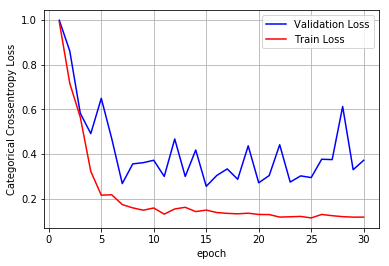

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label= "Validation Loss")
    ax.plot(x, ty, 'r', label= "Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
nb_epoch=30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## With 2 LSTM Layers

In [23]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(164, return_sequences = True, input_shape=(timesteps, input_dim)))
model1.add(Dropout(0.25))
model1.add(LSTM(64))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation= 'sigmoid'))
print(model1.summary())

# Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='rmsprop' ,metrics=['accuracy'])

# Training the model # batch_size=batch_size
history = model1.fit(X_train,Y_train,validation_data=(X_test, Y_test),epochs=30)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128, 164)          114144    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 164)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                58624     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 390       
Total params: 173,158
Trainable params: 173,158
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 59s 

In [18]:
scores1 = model1.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))

Accuracy: 92.26%


In [24]:
# Confusion Matrix
confusion_matrix(Y_test, model1.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,528,0,9,0,0,0
SITTING,5,418,65,1,0,2
STANDING,1,126,401,2,0,2
WALKING,6,0,1,452,15,22
WALKING_DOWNSTAIRS,2,0,0,2,395,21
WALKING_UPSTAIRS,0,0,0,1,0,470


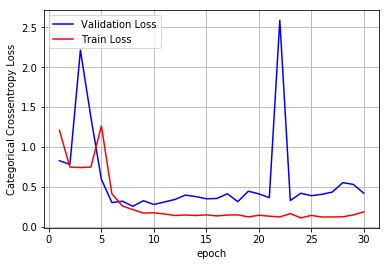

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label= "Validation Loss")
    ax.plot(x, ty, 'r', label= "Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
nb_epoch=30
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion :

In [27]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["LSTM_Model layers","epochs","train_accuracy","test_accuracy"])
x.add_row(['1 layer',30,95.16,93.00])
x.add_row(['2 layers',30,91.19,92.26])
print(x)

+-------------------+--------+----------------+---------------+
| LSTM_Model layers | epochs | train_accuracy | test_accuracy |
+-------------------+--------+----------------+---------------+
|      1 layer      |   30   |     95.16      |      93.0     |
|      2 layers     |   30   |     91.19      |     92.26     |
+-------------------+--------+----------------+---------------+


 * we have applied the batch normalization with dropout layer made to reach the 93% after many tests of training the model.
 * 2 layer LSTM model is nearly equal to 1 layer Lstm model. But still the Basic Machine learning models gave much better accuracy about 96% Than compared to complex Lstm models. 